In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as c
from cartopy import config
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

plt.rc('text',usetex=True) 
plt.rcParams['font.family']='sans-serif'
plt.rcParams['font.sans-serif']=['Verdana']
plt.rcParams.update({'font.size': 15})
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')  
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
            ax.xaxis.set_ticks([]) 


import sys
sys.path.append('/glade/work/kjmayer/research/catalyst/TransferLearning/runmean_analysis/artificial_bias/')
from utils import detrend_members

In [2]:
# get SST data:
path = '/glade/campaign/cgd/amp/jcaron/ongoing_projects/cvdp-le/output/final_cesm_e3sm_future_nonprime/1920-2100/'
ens = ['0101','0111','0121','0131','0141','0151','0161','0171','0181','0191',
       '0201','0211','0221','0231','0241','0251','0261','0271','0281','0291',
       '0301']

for e in range(len(ens)):
    finame = 'E3SM2_'+ens[e]+'.cvdp_data.1920-2100.nc'
    if e == 0:
        nino34 = xr.open_dataset(path+finame,decode_times=False)['nino34']
    elif e > 0:
        temp_nino34 = xr.open_dataset(path+finame,decode_times=False)['nino34']
        nino34 = xr.concat([nino34,temp_nino34],dim='ens')

newtime = pd.date_range("1920-01-01", freq="MS", periods=len(nino34.time))
nino34['time'] = newtime                           
nino34 = nino34.where((nino34.time.dt.year >= 1950) & (nino34.time.dt.year <= 2015), drop = True)
# nino34[0].plot()

nino34_ensmean = nino34.mean('ens')

nino34_detrended = detrend_members(data = nino34, 
                                   ensmean_data = nino34_ensmean, 
                                   npoly=3)

nino34_detrended_upsample = nino34_detrended.resample(time='1D').asfreq()
nino34_detrended_upsample = nino34_detrended_upsample.where(~((nino34_detrended_upsample.time.dt.month == 2) & (nino34_detrended_upsample.time.dt.day == 29)),drop=True)
nino34_detrended_upsample = nino34_detrended_upsample.ffill(dim='time')
nino34_detrended_upsample = nino34_detrended_upsample[:,6:-335] # 6: account for days 1-6 missing in X because of rolling mean; 
                                                                #-355: had to go through 2015 (not 2014) to get all days in Dec 2014 (not just 12-01-2014)

In [3]:
ppath = '/glade/derecho/scratch/kjmayer/DATA/E3SMv2/PRECT/'

# ------ LOAD & Add State-Dependent SHIFT --------
shift = 60

for m,mem in enumerate(ens):
    print(mem)
    pfiname = 'PRECT_mem'+ens[m]+'_7daymean_1950-2014_20S-20N_regrid2.5x2.5_polydetrend_allmems.nc'
    X = xr.open_dataarray(ppath+pfiname)
    
    inino = np.where(nino34_detrended_upsample[m] > 1)
    inina = np.where(nino34_detrended_upsample[m] < -1)
    
    if m == 0:
        Xnino = X[inino]
        Xnino_shift = X[inino].assign_coords(lon=np.append(np.arange(shift+2.5,360,2.5), np.arange(0,shift+2.5,2.5))).sortby('lon')# np.arange(182.5,360,2.5), np.arange(0,182.5,2.5))).sortby('lon')

        Xnina = X[inina]
        Xnina_shift = X[inina].assign_coords(lon=np.append(np.arange(shift+2.5,360,2.5), np.arange(0,shift+2.5,2.5))).sortby('lon')
    elif m > 0:
        Xnino = xr.concat([Xnino,X[inino]],dim='ens')
        Xnina = xr.concat([Xnina,X[inina]],dim='ens')
        
        Xnino_shift_temp = X[inino].assign_coords(lon=np.append(np.arange(shift+2.5,360,2.5), np.arange(0,shift+2.5,2.5))).sortby('lon')
        Xnino_shift = xr.concat([Xnino_shift,Xnino_shift_temp],dim='ens')
        
        Xnina_shift_temp = X[inina].assign_coords(lon=np.append(np.arange(shift+2.5,360,2.5), np.arange(0,shift+2.5,2.5))).sortby('lon')
        Xnina_shift = xr.concat([Xnina_shift,Xnina_shift_temp],dim='ens')


0101
0111
0121
0131
0141
0151
0161
0171
0181
0191
0201
0211
0221
0231
0241
0251
0261
0271
0281
0291
0301


In [13]:
# Xnino_mean = Xnino.mean(['ens','time'])
# Xnina_mean = Xnina.mean(['ens','time'])

# Xnino_shift_mean = Xnino_shift.mean(['ens','time'])
# Xnina_shift_mean = Xnina_shift.mean(['ens','time'])

Xnino_mean = Xnino[-1].mean(['time'])
# Xnina_mean = Xnina[-1].mean(['time'])

Xnino_shift_mean = Xnino_shift[-1].mean(['time'])
# Xnina_shift_mean = Xnina_shift[-1].mean(['time'])

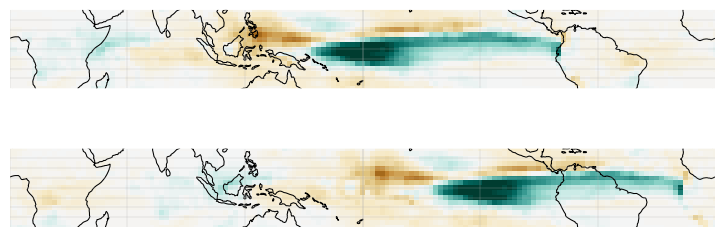

In [14]:
fig = plt.figure(figsize=(7.5,3))
ax = fig.subplot_mosaic('''
                        A
                        B
                        ''',subplot_kw={'projection':ccrs.PlateCarree(180)})
plt.tight_layout(w_pad=16)
for loc in ['A','B']:   
    ax[loc].coastlines(resolution='110m', color='k', linewidth=.75)
    ax[loc].set_ylim(-20,20)
    ax[loc].axis("off")
    gl = ax[loc].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=.2)
    gl.top_labels = False
    gl.right_labels = False
    gl.bottom_labels = False
    gl.left_labels = False
     
cmap = 'BrBG'
csm=plt.get_cmap(cmap)
norm = c.BoundaryNorm(np.arange(-5, 5.1, 0.1),csm.N)  

c1 = ax['A'].pcolormesh(Xnino_mean.lon, Xnino_mean.lat, Xnino_mean,cmap=csm,transform=ccrs.PlateCarree(),norm=norm)
c1 = ax['B'].pcolormesh(Xnino_shift_mean.lon, Xnino_shift_mean.lat, Xnino_shift_mean,cmap=csm,transform=ccrs.PlateCarree(),norm=norm)

# plt.show()
plt.savefig('plots/Figure1_precipshifts.png', dpi=300, transparent = True, bbox_inches = 'tight')

In [6]:
Xnino_latmean = Xnino_mean.mean('lat') 
Xnina_latmean = Xnina_mean.mean('lat')  
Xnino_shift_latmean = Xnino_shift_mean.mean('lat') 
Xnina_shift_latmean = Xnina_shift_mean.mean('lat')  

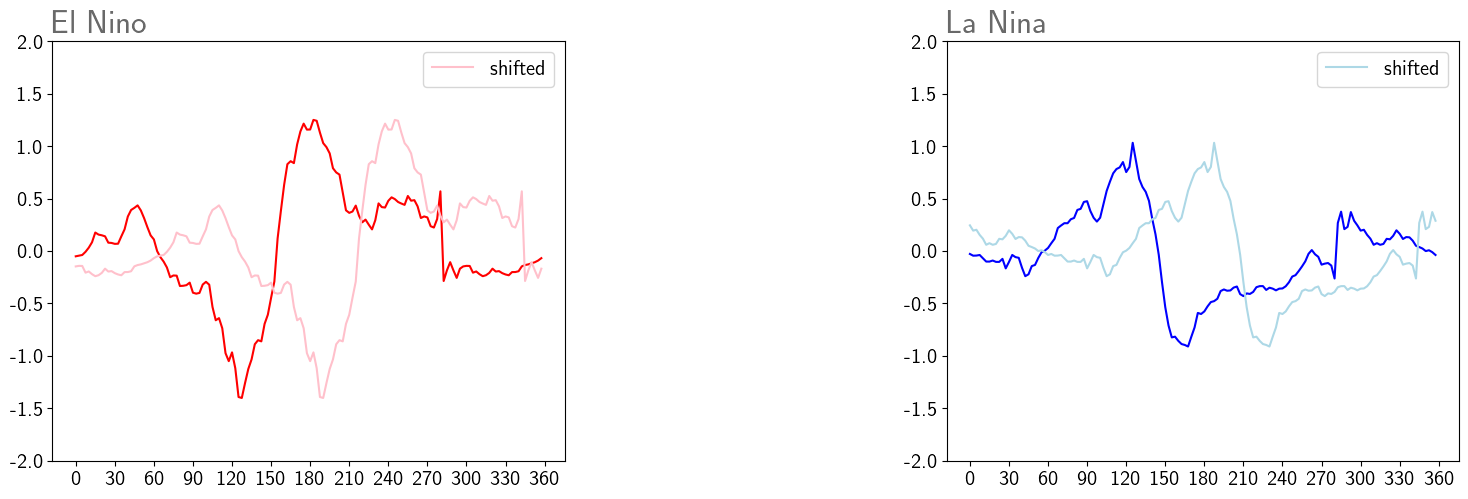

In [7]:
fig = plt.figure(figsize=(15,5))
ax = fig.subplot_mosaic('''
                        AB
                        ''')
plt.tight_layout(w_pad=16)

c1 = ax['A'].plot(Xnino_latmean,color='red')
ax['A'].set_title('El Nino ',fontsize=24,color='dimgrey',loc='left')
c1 = ax['A'].plot(Xnino_shift_latmean,color='pink',label='shifted')

ax['A'].set_xticks(np.arange(0,144+12,12),np.arange(0,390,30))
ax['A'].set_yticks(np.arange(-2,2.5,.5),np.arange(-2,2.5,.5))
ax['A'].legend()
# --
c1 = ax['B'].plot(Xnina_latmean,color='blue')
ax['B'].set_title('La Nina ',fontsize=24,color='dimgrey',loc='left')
c1 = ax['B'].plot(Xnina_shift_latmean,color='lightblue',label='shifted')

ax['B'].set_xticks(np.arange(0,144+12,12),np.arange(0,390,30))
ax['B'].set_yticks(np.arange(-2,2.5,.5),np.arange(-2,2.5,.5))
ax['B'].legend()

plt.show()